# Load library

In [3]:
%pip install s3fs

  Using cached s3fs-2024.3.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached fsspec-2024.3.1-py3-none-any.whl.metadata (6.8 kB)
Using cached s3fs-2024.3.1-py3-none-any.whl (29 kB)
Using cached fsspec-2024.3.1-py3-none-any.whl (171 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.9.1 requires faiss-cpu, which is not installed.
datasets 2.17.0 requires fsspec[http]<=2023.10.0,>=2023.1.0, but you have fsspec 2024.3.1 which is incompatible.
jupyter-scheduler 2.5.1 requires fsspec==2023.6.0, but you have fsspec 2024.3.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [41]:
import pandas as pd
import os
import boto3
import datetime

In [42]:
print('start time:', datetime.datetime.now())

# Load data from csv
s3_client = boto3.client("s3")

bucket_name = 'eliezerraj-908671954593-dataset'
prefix_name = 'payment-rcf/notebook'
file_name = 'payment.csv'

data_location = 's3://{}/{}/{}'.format(bucket_name, prefix_name, file_name)

df_data = pd.read_csv(data_location)

print("---------------------------------")
print(f"Shape of dataframe '{df_data.shape}':")

pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
df_data.head()

start time: 2024-05-04 01:36:07.292890
---------------------------------
Shape of dataframe '(51795, 25)':


,id,fk_card_id,card_number,terminal_name,coord_x,coord_y,card_type,card_model,payment_at,mcc,amount,night_day,ic_night_day,wkend_wkday,ic_wkend_wkday,day_of_year,tx_1d,avg_1d,tx_7d,avg_7d,tx_30d,avg_30d,time_btw_tx,time_btw_cc_tx,fraud
0,26965,843,111.111.000.843,TERM-221,222.0,261.0,CREDIT,VIRTUAL,2024-03-19 21:03:38.0,GAS,840.0,night,1,wkday,0,79.0,4,857.25,6,659.17,14,408.07,63,26,1
1,37036,636,111.111.000.636,TERM-59,38.0,34.0,CREDIT,VIRTUAL,2024-04-18 18:57:19.0,LAUNDRY,142.0,day,0,wkday,0,109.0,1,142.00,3,274.67,10,254.30,149,0,0
2,28164,538,111.111.000.538,TERM-24,77.0,45.0,CREDIT,CHIP,2024-03-23 15:47:16.0,SPORTING,408.0,day,0,wkend,1,83.0,3,209.33,3,209.33,6,207.17,8,1802,0
3,41128,517,111.111.000.517,TERM-97,8.0,85.0,CREDIT,CHIP,2024-04-30 18:52:27.0,CINEMA,106.0,day,0,wkday,0,121.0,2,109.50,2,109.50,8,210.75,22,997,0
4,37698,56,111.111.000.056,TERM-48,94.0,54.0,CREDIT,CHIP,2024-04-20 17:46:19.0,LAUNDRY,106.0,day,0,wkend,1,111.0,2,303.00,7,551.00,13,743.23,64,0,0


# Featuring Engineiring

In [43]:
df_payment = df_data.filter(['fraud',
                'payment_at',
                'terminal_name',
                'coord_x',
                'coord_y',
                'card_type',
                'card_model',
                'mcc',
                'amount',
                'tx_1d',
                'avg_1d',
                'tx_7d',
                'avg_7d',
                'tx_30d',
                'avg_30d',
                'time_btw_cc_tx'], axis=1)

In [44]:
# Create a new column distance
import math

df_payment.insert(5, "distance", 0)
for ind in df_payment.index:
    p1 = [0, 0]
    p2 = [df_payment['coord_x'][ind], df_payment['coord_y'][ind]]
    distance = math.sqrt(((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2))
    df_payment["distance"][ind] = distance

/tmp/ipykernel_175/1145077485.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payment["distance"][ind] = distance
/tmp/ipykernel_175/1145077485.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '342.64413025761877' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_payment["distance"][ind] = distance


In [45]:
# extract hour
df_payment["ts_payment_at"] = pd.to_datetime(df_payment['payment_at'])

print("df_payment.dtype: ", df_payment.ts_payment_at.dtype)

df_payment["hour"] = df_payment.ts_payment_at.dt.hour

df_payment["dt_payment"] = df_payment.ts_payment_at.dt.date

df_payment.dtype:  datetime64[ns]


In [46]:
# 2nd filter dataframe
df_payment = df_payment.filter(['fraud',
                                'dt_payment',
                                'hour',
                                'distance',
                                'card_type',
                                'card_model',
                                'mcc',
                                'amount',
                                'tx_1d',
                                'avg_1d',
                                'tx_7d',
                                'avg_7d',
                                'tx_30d',
                                'avg_30d',
                                'time_btw_cc_tx'], axis=1)

df_payment.head(3)

,fraud,dt_payment,hour,distance,card_type,card_model,mcc,amount,tx_1d,avg_1d,tx_7d,avg_7d,tx_30d,avg_30d,time_btw_cc_tx
0,1,2024-03-19,21,342.644130,CREDIT,VIRTUAL,GAS,840.0,4,857.25,6,659.17,14,408.07,26
1,0,2024-04-18,18,50.990195,CREDIT,VIRTUAL,LAUNDRY,142.0,1,142.00,3,274.67,10,254.30,0
2,0,2024-03-23,15,89.185201,CREDIT,CHIP,SPORTING,408.0,3,209.33,3,209.33,6,207.17,1802


In [47]:
df_payment = pd.get_dummies(df_payment,
                            columns=['card_model', ],
                            prefix='card_model',
                            dtype=int,
                            drop_first=False)

df_payment = pd.get_dummies(df_payment,
                            columns=['card_type', ],
                            prefix='card_type',
                            dtype=int,
                            drop_first=False)

In [48]:
df_payment.head(3)

,fraud,dt_payment,hour,distance,mcc,amount,tx_1d,avg_1d,tx_7d,avg_7d,tx_30d,avg_30d,time_btw_cc_tx,card_model_CHIP,card_model_VIRTUAL,card_type_CREDIT
0,1,2024-03-19,21,342.644130,GAS,840.0,4,857.25,6,659.17,14,408.07,26,0,1,1
1,0,2024-04-18,18,50.990195,LAUNDRY,142.0,1,142.00,3,274.67,10,254.30,0,0,1,1
2,0,2024-03-23,15,89.185201,SPORTING,408.0,3,209.33,3,209.33,6,207.17,1802,1,0,1


# View Data

<Axes: title={'center': 'Class distribution of the target variable'}, xlabel='fraud'>

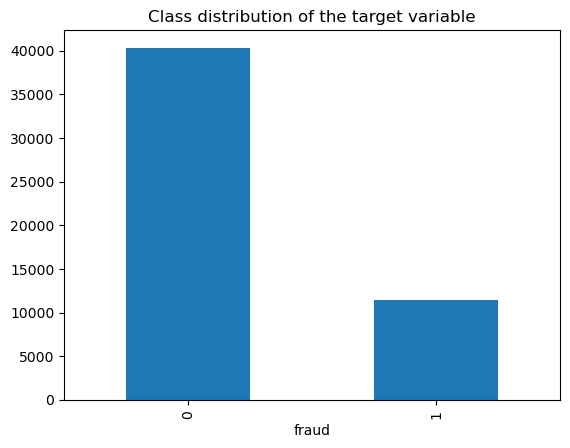

In [49]:
value_counts = df_payment["fraud"].value_counts()
value_counts.plot(kind="bar", title="Class distribution of the target variable")

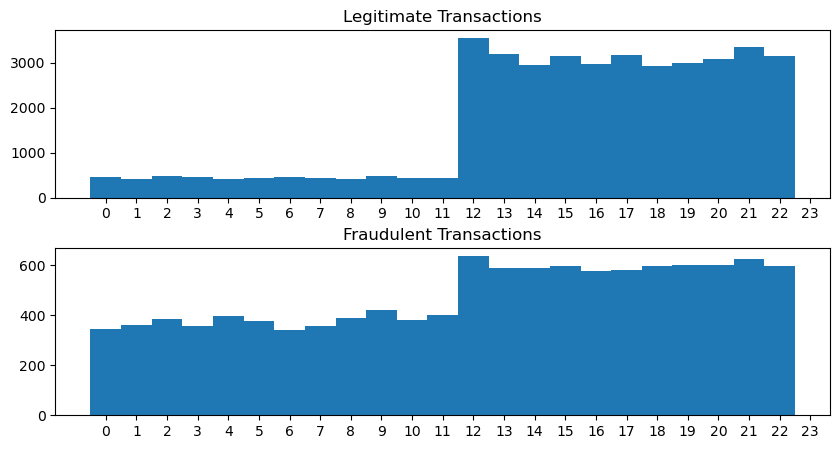

In [50]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, figsize=(10,5))
for a in ax:
    a.set_xticks(range(24))
df_payment.loc[df_payment["fraud"] == 0]["hour"].hist(bins=np.arange(24)-0.5, ax=ax[0], grid=False)
df_payment.loc[df_payment["fraud"] == 1]["hour"].hist(bins=np.arange(24)-0.5, ax=ax[1], grid=False)
ax[0].title.set_text("Legitimate Transactions")
ax[1].title.set_text("Fraudulent Transactions")
plt.subplots_adjust(hspace=0.3)

In [51]:
# Determine number of fraud cases in dataset

Fraud = df_payment[df_payment['fraud'] == 1]
Valid = df_payment[df_payment['fraud'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(df_payment[df_payment['fraud'] == 1])))
print('Valid Transactions: {}'.format(len(df_payment[df_payment['fraud'] == 0])))

0.28412049088880625
Fraud Cases: 11460
Valid Transactions: 40335


In [52]:
print("Amount details of fradulent transacation")
df_payment.fraud.describe()

Amount details of fradulent transacation


count    51795.000000
mean         0.221257
std          0.415097
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: fraud, dtype: float64